# Applying Different Types of Regression Models

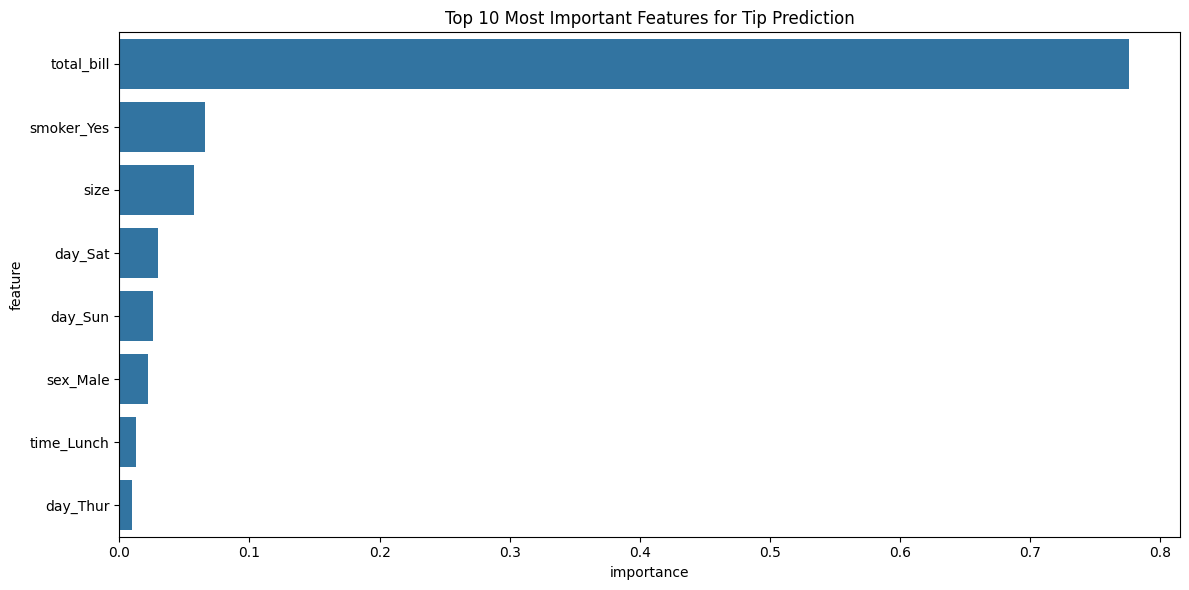


Average Tip Percentage by Day and Time:
time     Dinner      Lunch
day                       
Fri   15.891611  18.876489
Sat   15.315172        NaN
Sun   16.689729        NaN
Thur  15.974441  16.130074

Correlation between total bill and tip: 0.676

Model Performance Summary:
Linear Regression: R² = 0.421 (±0.135)
Ridge: R² = 0.423 (±0.133)
Lasso: R² = -0.023 (±0.017)
Decision Tree: R² = 0.104 (±0.164)
Random Forest: R² = 0.401 (±0.121)
SVR: R² = 0.405 (±0.130)
KNN: R² = 0.338 (±0.083)


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the data
data = pd.read_csv('tips.csv')

# Calculate tip percentage
data['tip_percent'] = (data['tip'] / data['total_bill']) * 100

# 1. Feature Engineering and Data Preparation
X = data[['total_bill', 'size', 'sex', 'smoker', 'day', 'time']]
y = data['tip']

# Create preprocessor
numeric_features = ['total_bill', 'size']
categorical_features = ['sex', 'smoker', 'day', 'time']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# 2. Model Creation and Evaluation
def evaluate_model(model, name, X, y):
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    # Fit model for feature importance (if applicable)
    pipeline.fit(X, y)

    return {
        'name': name,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'pipeline': pipeline
    }

# Create and evaluate models
models = [
    (LinearRegression(), 'Linear Regression'),
    (Ridge(alpha=1.0), 'Ridge'),
    (Lasso(alpha=1.0), 'Lasso'),
    (DecisionTreeRegressor(random_state=42), 'Decision Tree'),
    (RandomForestRegressor(random_state=42), 'Random Forest'),
    (SVR(kernel='rbf'), 'SVR'),
    (KNeighborsRegressor(n_neighbors=5), 'KNN')
]

results = []
for model, name in models:
    result = evaluate_model(model, name, X, y)
    results.append(result)

# 3. Feature Importance Analysis
# Using Random Forest for feature importance
rf_pipeline = results[4]['pipeline']
feature_names = (numeric_features +
                [f"{feat}_{val}" for feat, vals in
                 zip(categorical_features,
                     rf_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat'].categories_)
                 for val in vals[1:]])

importances = rf_pipeline.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# 4. Visualizations
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features for Tip Prediction')
plt.tight_layout()
plt.show()

# 5. Additional Analysis
# Tip percentage by day and time
avg_tip_by_day_time = data.groupby(['day', 'time'])['tip_percent'].mean().unstack()
print("\nAverage Tip Percentage by Day and Time:")
print(avg_tip_by_day_time)

# Correlation between total bill and tip
correlation = data['total_bill'].corr(data['tip'])
print(f"\nCorrelation between total bill and tip: {correlation:.3f}")

# Model Performance Summary
print("\nModel Performance Summary:")
for result in results:
    print(f"{result['name']}: R² = {result['cv_mean']:.3f} (±{result['cv_std']:.3f})")

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow



# Scatter Plot





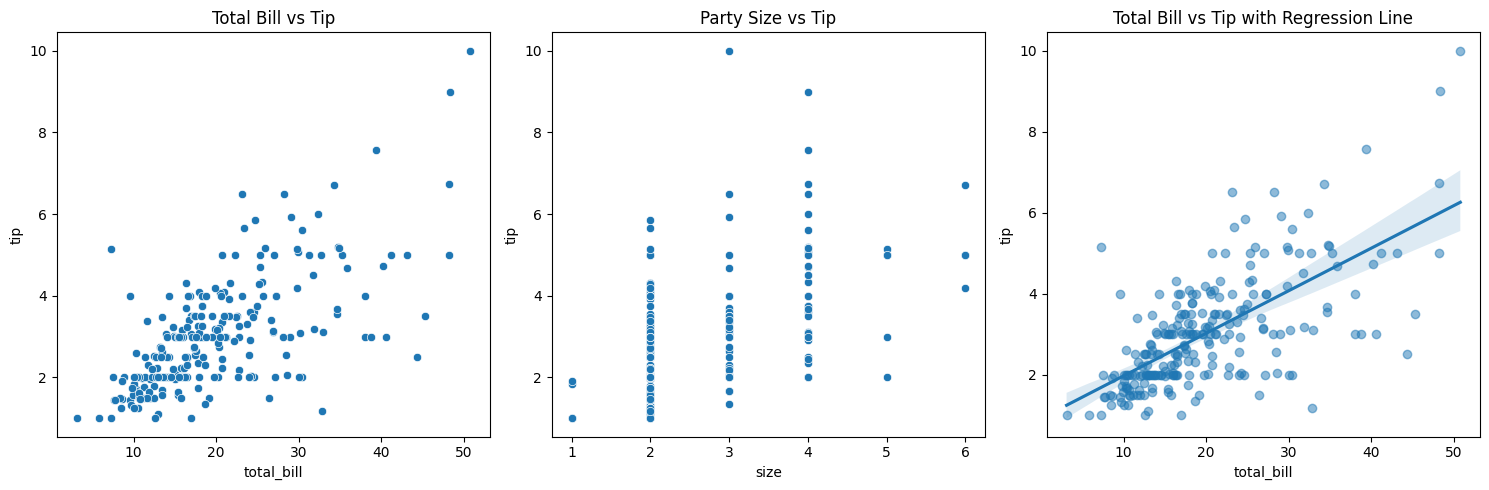

In [7]:
# Create numerical features DataFrame
numeric_data = data[['total_bill', 'tip', 'size']]

# 1. Scatter Plots
plt.figure(figsize=(15, 5))

# Total Bill vs Tip
plt.subplot(131)
sns.scatterplot(data=data, x='total_bill', y='tip')
plt.title('Total Bill vs Tip')

# Size vs Tip
plt.subplot(132)
sns.scatterplot(data=data, x='size', y='tip')
plt.title('Party Size vs Tip')

# Add regression lines
plt.subplot(133)
sns.regplot(data=data, x='total_bill', y='tip', scatter_kws={'alpha':0.5})
plt.title('Total Bill vs Tip with Regression Line')

plt.tight_layout()
plt.show()

#Pair Plot



<Figure size 1000x1000 with 0 Axes>

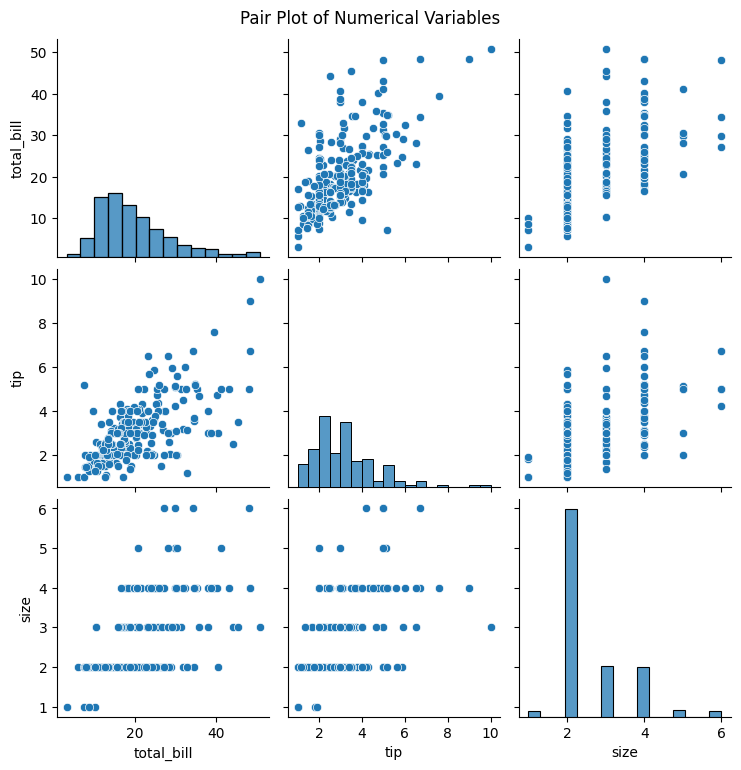

In [8]:
# 2. Pair Plot
plt.figure(figsize=(10, 10))
sns.pairplot(numeric_data)
plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
plt.show()


# Correlation Matrix

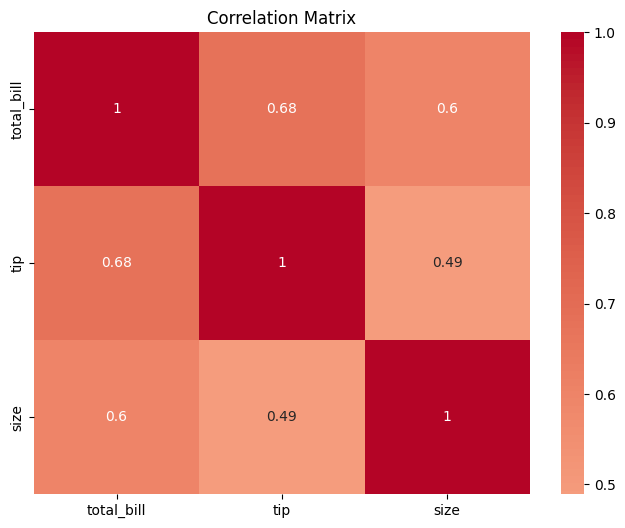

In [9]:
# 3. Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#Rainbow Test for Linearity

In [12]:
# 4. Rainbow Test for Linearity
X = sm.add_constant(data['total_bill'])
y = data['tip']
model = sm.OLS(y, X).fit()
rainbow_statistic, rainbow_p_value = linear_rainbow(model)

# Residuals Plot

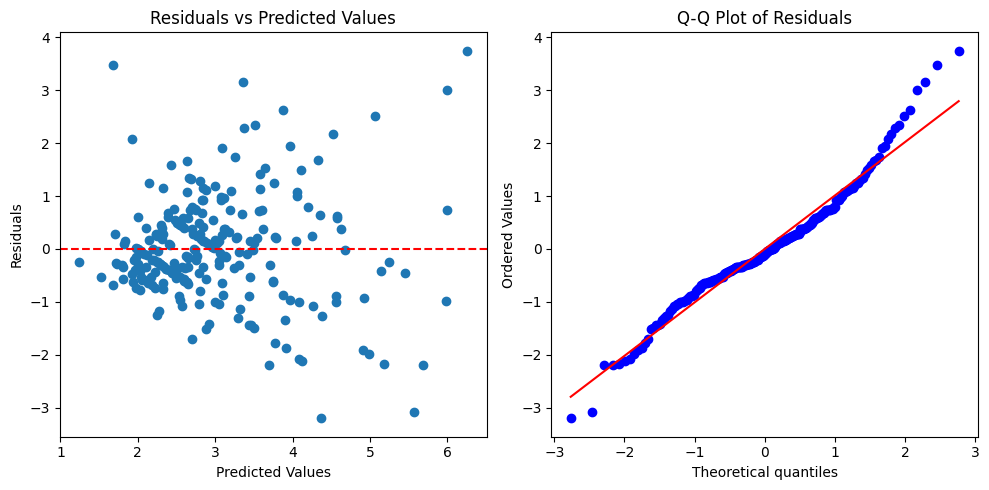

In [13]:
# 5. Residuals Plot
def plot_residuals(X, y):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    predictions = model.predict(X.reshape(-1, 1))
    residuals = y - predictions

    plt.figure(figsize=(10, 5))

    # Residuals vs Predicted
    plt.subplot(121)
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')

    # Q-Q Plot
    plt.subplot(122)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

plot_residuals(data['total_bill'].values, data['tip'].values)

# Time-series Analysis (using order of data as proxy for time)

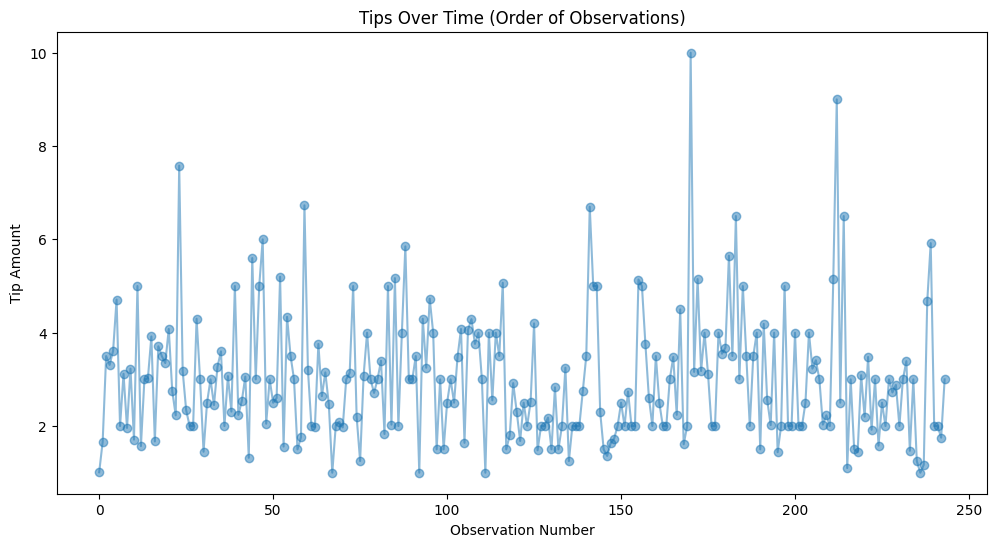

In [14]:
# 6. Time-series Analysis (using order of data as proxy for time)
plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), data['tip'], marker='o', linestyle='-', alpha=0.5)
plt.title('Tips Over Time (Order of Observations)')
plt.xlabel('Observation Number')
plt.ylabel('Tip Amount')
plt.show()

# Non-linear Pattern Check using Polynomial Features

In [15]:
# 7. Non-linear Pattern Check using Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


# Compare Linear vs Polynomial Regression
X = data['total_bill'].values.reshape(-1, 1)
y = data['tip'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_score = r2_score(y_test, linear_model.predict(X_test))

# Polynomial Model (degree=2)
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])
poly_model.fit(X_train, y_train)
poly_score = r2_score(y_test, poly_model.predict(X_test))

# Print Results
print("\nLinearity Analysis Results:")
print(f"Rainbow Test Statistic: {rainbow_statistic:.4f}")
print(f"Rainbow Test p-value: {rainbow_p_value:.4f}")
print(f"\nLinear Model R² Score: {linear_score:.4f}")
print(f"Polynomial Model R² Score: {poly_score:.4f}")

# Calculate additional statistical measures
print("\nStatistical Measures:")
print("Skewness:")
print(numeric_data.skew())
print("\nKurtosis:")
print(numeric_data.kurtosis())


Linearity Analysis Results:
Rainbow Test Statistic: 1.2291
Rainbow Test p-value: 0.1291

Linear Model R² Score: 0.5449
Polynomial Model R² Score: 0.5300

Statistical Measures:
Skewness:
total_bill    1.133213
tip           1.465451
size          1.447882
dtype: float64

Kurtosis:
total_bill    1.218484
tip           3.648376
size          1.731700
dtype: float64


# Recommendations for Management

Recommendations for Management
1. Focus on Group Size Patterns:Tailor tipping expectations and service for different group sizes, especially larger groups, as they generally tip more.
2. Optimize Staffing on High-Tip Days:
Increase staff on Sundays and Fridays to maximize service quality and revenue from peak tipping days.
3.Use Total Bill as the Primary Predictive Factor:
Emphasize total bill in forecasting tips, as it has the most significant impact across all groups, except size 5.